!pip install simpy
!pip install ortools
!pip install combalg

In [1]:
from ortools.graph import pywrapgraph
import numpy as np

Define graph structure<br/>
Define supplies and demands

<b>MAP route for BUS 255</b><br/>
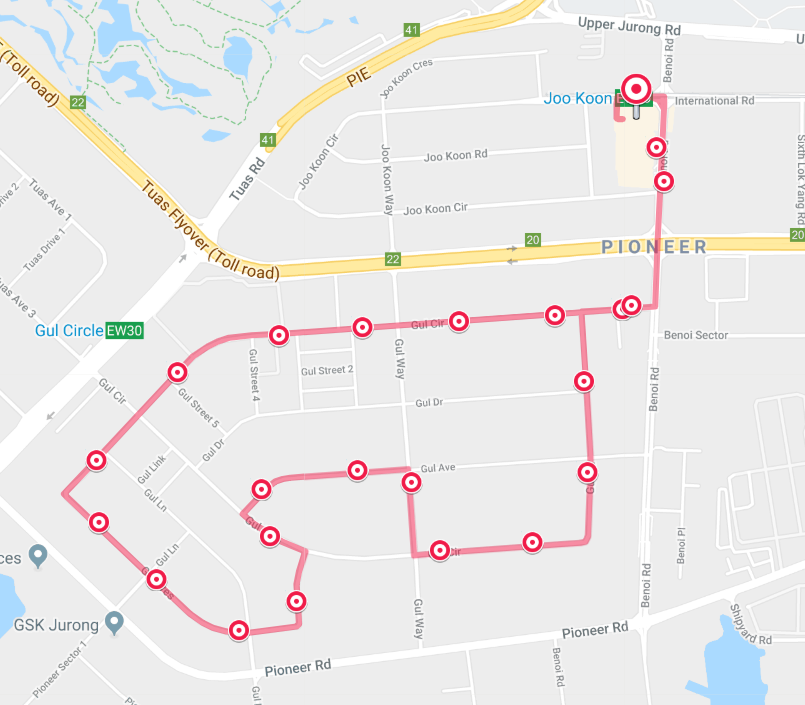

In [2]:
start = [0, 1, 2, 3, 3, 4, 4, 5, 6, 7,  7,  7,  7,  7, 7, 8, 9,  10, 11, 12, 13, 13, 14, 15, 4, 16, 16, 17, 17, 18, 16, 18, 19, 19, 20, 19, 21, 4, 4, 9,22]
end =   [1, 2, 3, 2, 4, 3, 5, 6, 7, 13, 14, 16, 9, 10, 8, 9, 10, 11, 12, 13, 17, 14, 15, 16, 16, 4, 17, 16, 18, 17, 20, 19, 18, 20, 21, 21, 22, 19, 20, 20,0]
distance = [1200, 600, 210, 210, 300, 300, 350, 300, 450, 900, 900, 1300, 700, 900, 450, 350, 300, 400, 300, 350, 650, 250, 400,
           250, 850, 850, 350, 350, 350, 350, 1400, 450, 450, 350, 450, 600, 1800, 1100, 750, 2400, 9999999]

<b>RESULTING GRAPH</b>

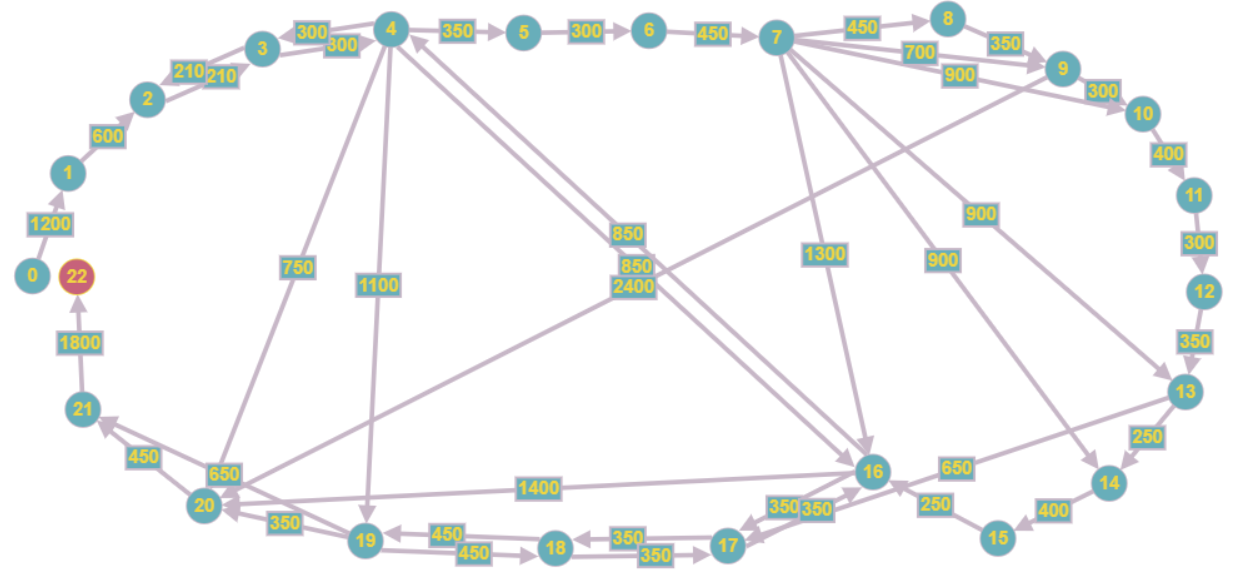

In [3]:
def optimize_route(start, end, distance, passengers):
    print("Demand:",passengers)
    #Casting to int to avoid TypeError in MinCostFlowBase
    passengers = [int(i) for i in passengers]
    capacities = [96 for star in start]
    mincostflow = pywrapgraph.SimpleMinCostFlow()
    for i in range(0,len(start)):
        mincostflow.AddArcWithCapacityAndUnitCost(start[i],end[i],capacities[i],distance[i])
    for i in range(0,len(passengers)):
        mincostflow.SetNodeSupply(i,passengers[i])
    if mincostflow.Solve() == mincostflow.OPTIMAL:
        return mincostflow
    else:
        print("There was an issue with the min cost flow input.")

In [4]:
def decomposition(i,k):
        list=[]
        while i != 1 and k-1 > 0:
            n = np.random.randint(1, i)
            list.append(n)
            i -= n
            k -= 1
        list.append(i)
        return list

In [5]:
def poisson_people(rate,start,end):
    demand = [0 for star in range(max(start)+1)]
    #print(demand)
    demand_index = list(np.random.randint(2,size=max(start)+1))
    #print(demand_index)
    for i in range(0,len(demand_index)):
        if demand_index[i] == 1:
            people = np.random.poisson(rate,1)
            demand[i] += people[0]
            #print('People',people)
            #print('Demand',demand)
            if people[0] > 0:
                drop_offs = decomposition(people[0],max(start)-i)
                #print('Drop-offs',drop_offs)
                for j in range(max(start) if i == max(start) else i+1,i+1+len(drop_offs) if i < max(start) else max(start)+1):
                    #print(j)
                    demand[j] -= drop_offs[j-i-1]
            else:
                demand[i] += 0
        else:
            demand[i] += 0
    return demand

In [6]:
opt_network = optimize_route(start, end, distance, poisson_people(3,start,end))
print('  Arc    Flow / Capacity  Distance')
for i in range(opt_network.NumArcs()):
    if opt_network.Flow(i) != 0:
        distance = opt_network.UnitCost(i)
    else:
        distance = 0
    print('%1s -> %1s   %3s  / %3s       %3s' % (
          opt_network.Tail(i),
          opt_network.Head(i),
          opt_network.Flow(i),
          opt_network.Capacity(i),
          distance))

Demand: [0, 0, 0, 0, 0, 0, 4, 3, -1, 1, -5, -1, -1, 5, -1, 2, -3, 1, 1, -1, -3, -1, 0]
  Arc    Flow / Capacity  Distance
0 -> 1     0  /  96         0
1 -> 2     0  /  96         0
2 -> 3     0  /  96         0
3 -> 2     0  /  96         0
3 -> 4     0  /  96         0
4 -> 3     0  /  96         0
4 -> 5     0  /  96         0
5 -> 6     0  /  96         0
6 -> 7     4  /  96       450
7 -> 13     0  /  96         0
7 -> 14     0  /  96         0
7 -> 16     0  /  96         0
7 -> 9     0  /  96         0
7 -> 10     6  /  96       900
7 -> 8     1  /  96       450
8 -> 9     0  /  96         0
9 -> 10     1  /  96       300
10 -> 11     2  /  96       400
11 -> 12     1  /  96       300
12 -> 13     0  /  96         0
13 -> 17     3  /  96       650
13 -> 14     2  /  96       250
14 -> 15     1  /  96       400
15 -> 16     3  /  96       250
4 -> 16     0  /  96         0
16 -> 4     0  /  96         0
16 -> 17     0  /  96         0
17 -> 16     0  /  96         0
17 -> 18     

In [9]:
print("Optimal Distance travelled for service:",sum([opt_network.UnitCost(i) for i in range(opt_network.NumArcs()) if opt_network.Flow(i) != 0]),"metres")
if sum([opt_network.UnitCost(i) for i in range(opt_network.NumArcs()) if opt_network.Flow(i) != 0]) > 10201:
    print("This demand sequence will be better met with regular service")
else:
    print("This demand is better served with dynamic routing")

Optimal Distance travelled for service: 6100 metres
This demand is better served with dynamic routing


In [57]:
print("WITHIN GEOFENCE | Fuel Cost   |   Manpower Cost   |   Operation Cost(A/C)")
print("Dynamic Routing |", round(sum([opt_network.UnitCost(i) for i in range(opt_network.NumArcs()) if opt_network.Flow(i) != 0])/2500 * 1.85),"S$","       |  ", round(5*5*0.2),"S$","           |  ", round(0.9*sum([opt_network.UnitCost(i) for i in range(opt_network.NumArcs()) if opt_network.Flow(i) != 0])/1000),"S$")
print("Usual Operating |", round(10.21/2.5 * 1.85),"S$","       |  ", round(30*0.2),"S$","           |  ", round(0.9*10.21),"S$")

WITHIN GEOFENCE | Fuel Cost   |   Manpower Cost   |   Operation Cost(A/C)
Dynamic Routing | 5 S$        |   5 S$            |   6 S$
Usual Operating | 8 S$        |   6 S$            |   9 S$


<b>Fuel Cost</b>: <br/>
As per <a href = "https://media.daimler.com/marsMediaSite/en/instance/ko/Promise-kept-demonstrably-lower-fuel-consumption-with-Euro-VI-certified-Mercedes-Benz-Citaro-and-Setra-ComfortClass.xhtml?oid=9904236">Mercedes Citaro</a> mileage of 2.5 km per diesel litre and diesel price of 1.85 SGD<br/>
<b>Manpower Cost</b>: <br/>
As per <a href = https://towertransit.sg/news/tower-transit-to-offer-attractive-pay-professional-job-scopes-opportunities-for-career-progression-attractive-benefits-and-family-friendly-leave-entitlements/>article</a> 8 S$ per hour --> converted to 0.2 SGD per min --> calculated for all buses and avg of 5 mins per bus in above simulation<br/>
<b>Operating Cost</b>:<br/>
Assumed half of fuel cost i.e 0.9 per km

<b>Travel Distance due to service : 6.1 km<br/>
Default travel distance : 10.21 km<br/>
Number of buses deployed to satisfy service : 5<br/>
Number of via travels : 2</b>

Bus 1 route:<br/>
Demands: There are a total of 5 demands at SNL Logistics. 1 of them want to go to Aft Gul Avenue, 1 of them want to go to W Atelier/Opp Tuboscope Vecto and 3 of them want to go to Sing Huat Hardware.<br/>

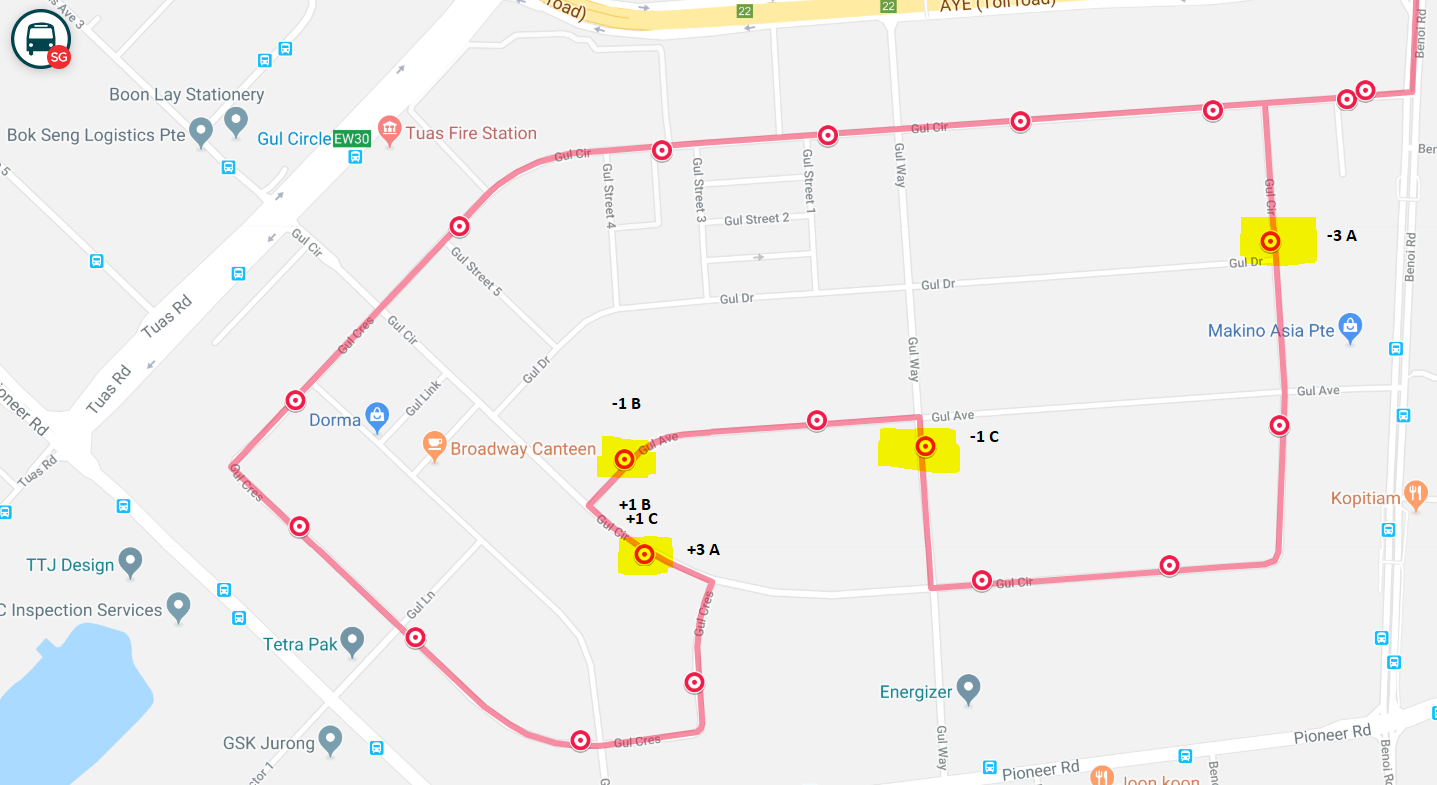

<b>Other Demands</b>
One person at Aft Gul Way want to go to Cameron Iron Works<br/>
Another person at Opp Keppel T & T wants to go to Aft Benoi Rd
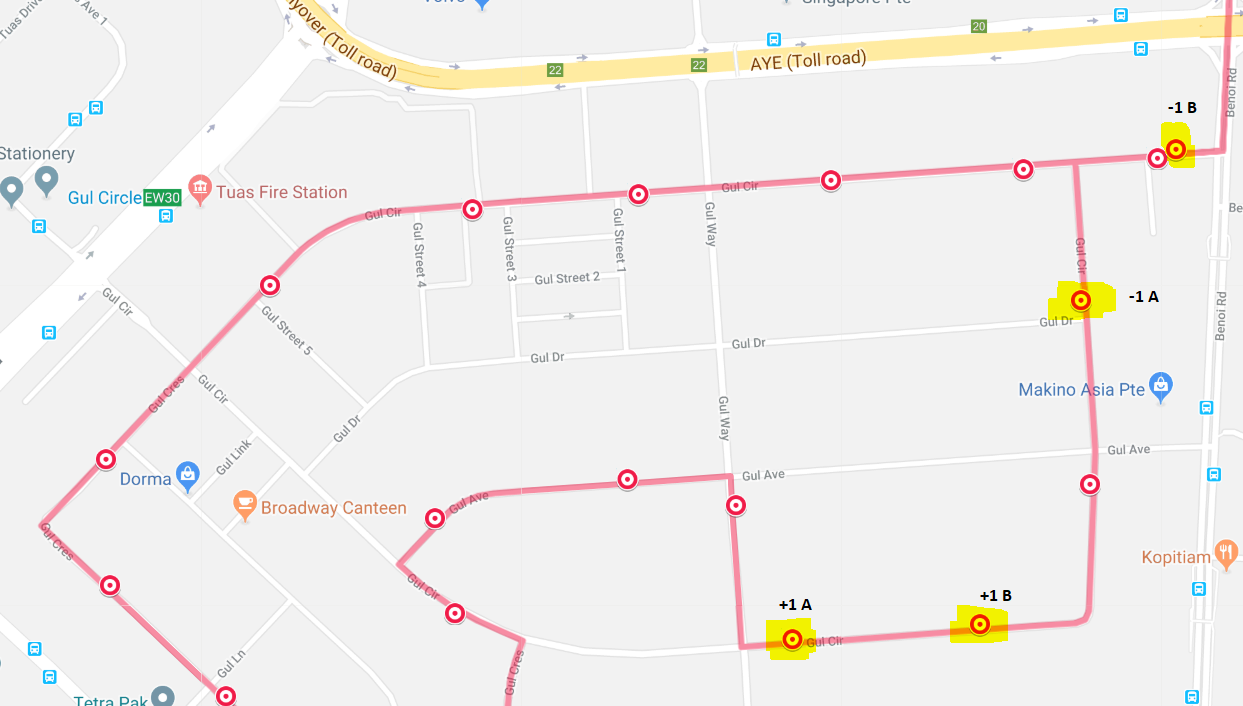

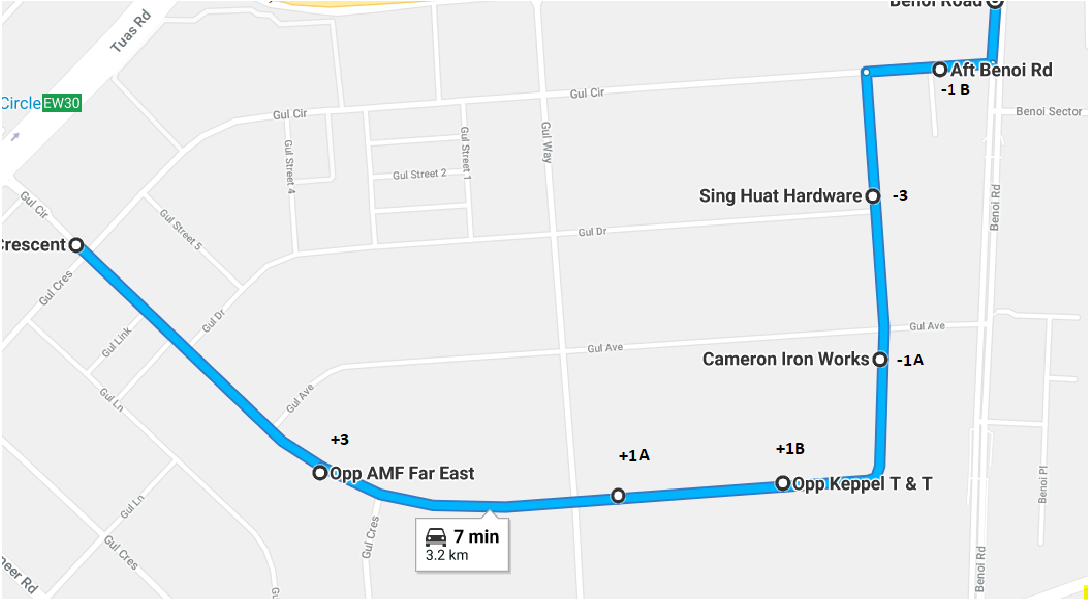
Total Customers served in GeoFence: 5

Bus 2 route:<br/>
Other Demands: 2 people get in at Metall Treat Ind and want to get down at Aft Gul Ave. So second bus comes in through 19 Gul Way, serves 4 customers and goes back through 19 Gul Way and out of the GeoFence
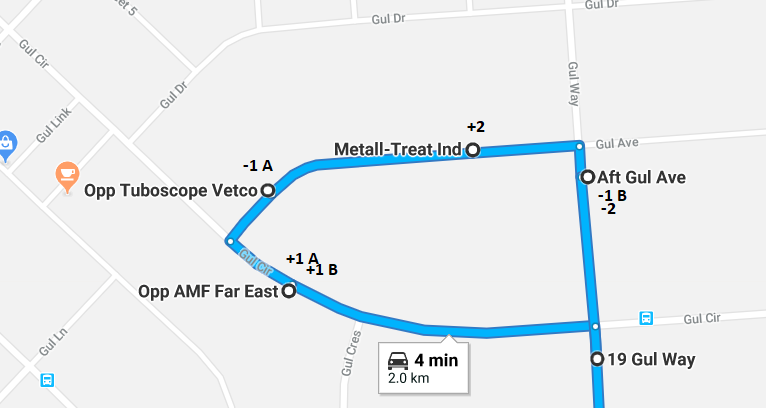

Bus 3 Route:<br/>
Demands: 4 people are there at Aft Gul St 3 of which want to go to Tai Sin Electric Cables and 1 want to go to Aft Gul Lane.<br/>
3 people at Precision Products, 2 want to go to Tai Sin Electric Cables and 1 want to go to Bef Gul Circle.
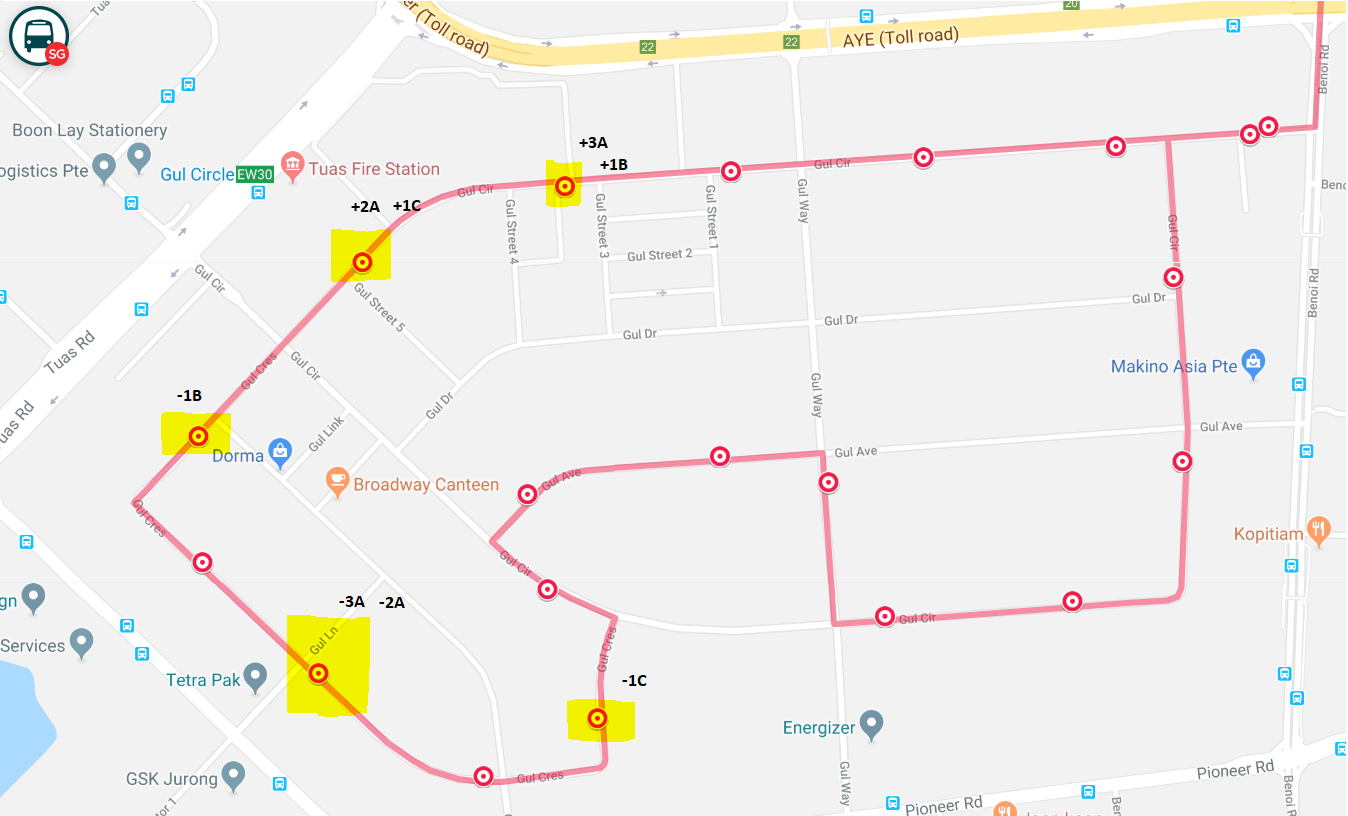

Concept of via travels
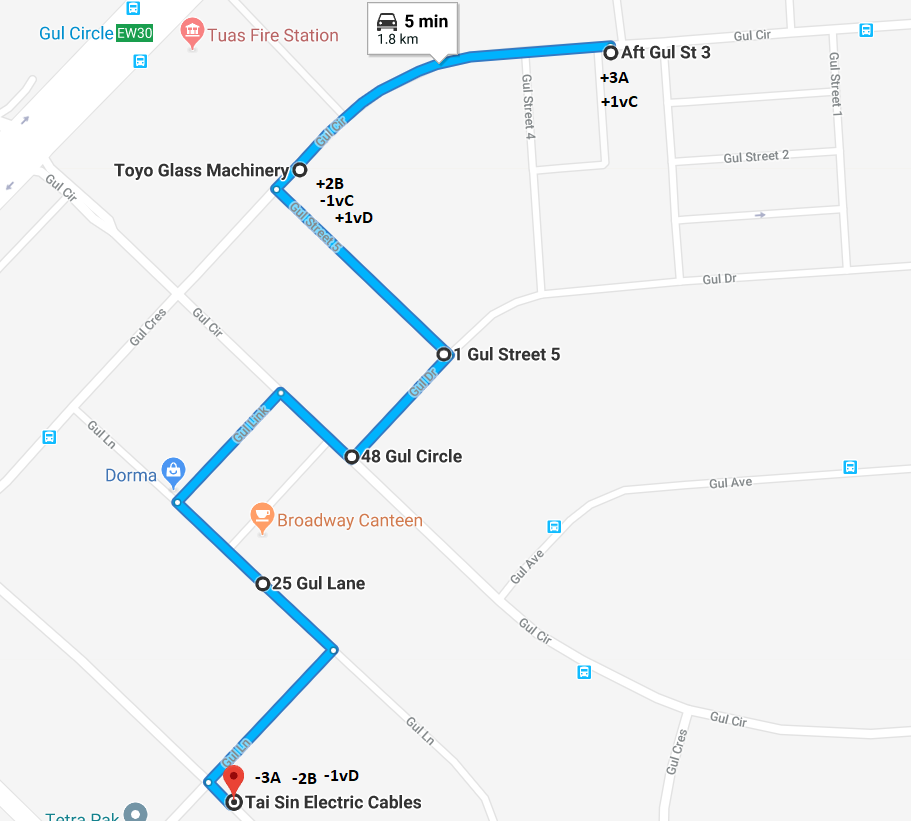

Bus 4 Route:<br/>
Other Demands: There is 1 person at JB Industries Pvt Ltd who wants to go to Opp Hong Hock Hardware.<br/>
A new bus comes into the GeoFence via Gul Circle 103 Lane.<br/>
This bus services the viaD person and this additional demand, and leaves the GeoFence to service other demands.
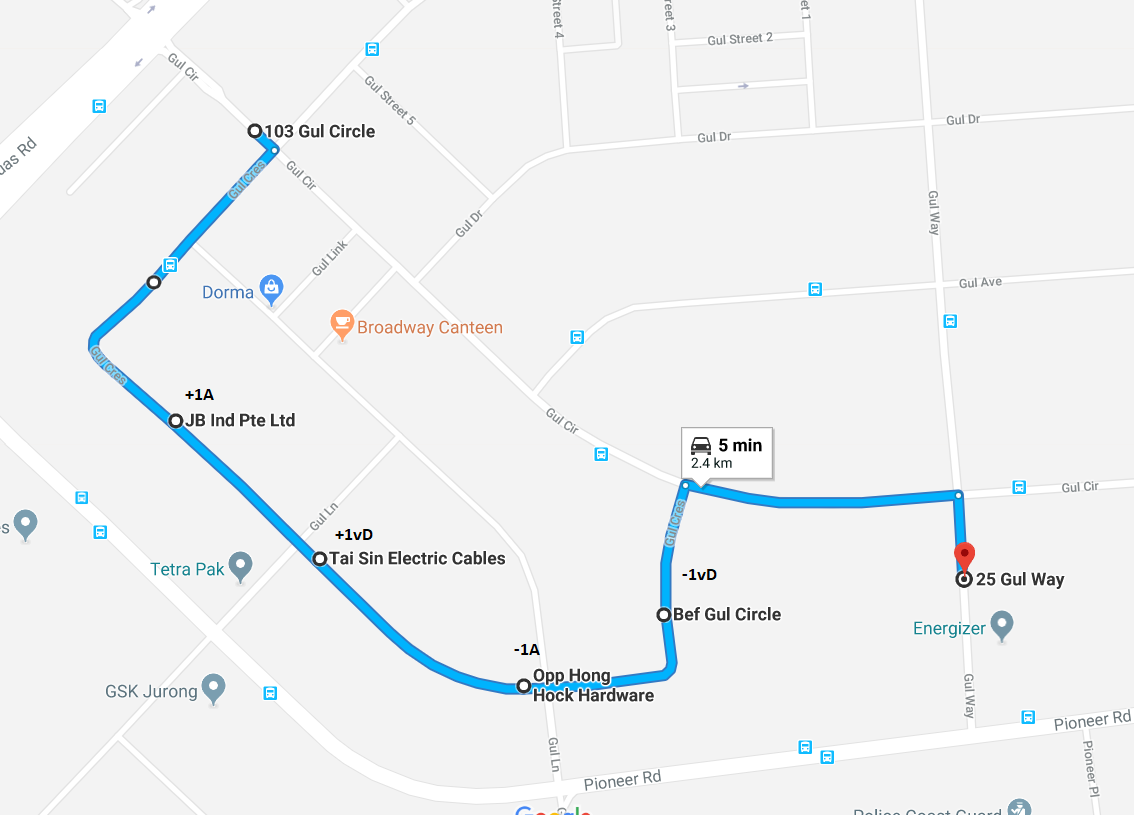

Bus 5 Route:
The Final via Demand viaC from Bus 3 is serviced now. A new bus arrives from Tuas Rd and services this request and leaves the GeoFence.
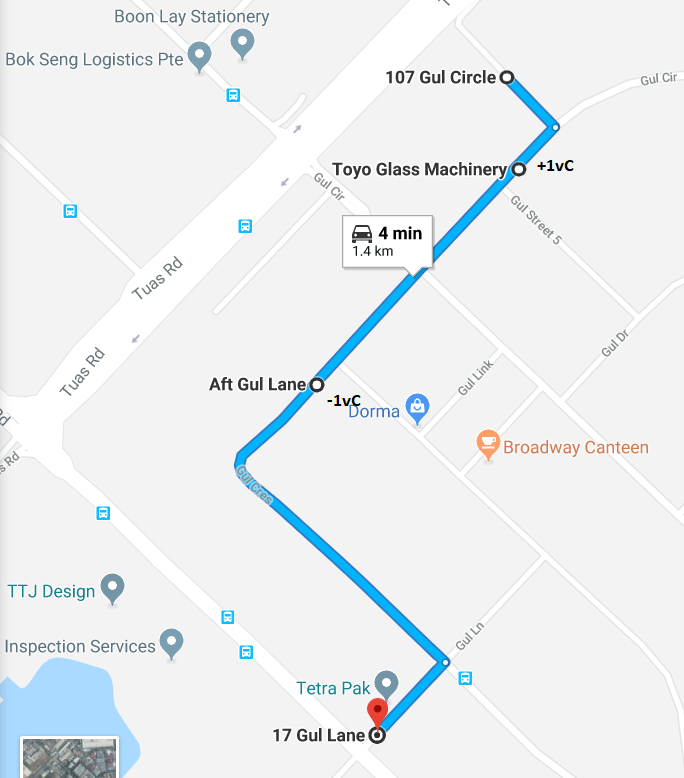